## About This Notebook

In this notebook, data on SpaceX rocket launches is collected from an API. Then, the collected data is analyzed and used to build classification models predicting the outcomes of Falcon 9 rocket launches.

## Setting Up Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Libraries for working with the data
import requests
import pandas as pd
import numpy as np
import datetime

#Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for machine learning models
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

## Data Collection and Wrangling

Let's start requesting rocket launch data from SpaceX API.

In [3]:
spacex_url='https://api.spacexdata.com/v4/launches/past'
response = requests.get(spacex_url)

In [4]:
response.status_code

200

The status code 200 indicates that the request was successful. Now we can convert the JSON result into a data frame.

In [5]:
data = pd.json_normalize(response.json())
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
data.head()

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/94/f2/NN6Ph45r_o.png,https://images2.imgbox.com/5b/02/QcxHUb5V_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]","Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/f9/4a/ZboXReNb_o.png,https://images2.imgbox.com/80/a2/bkWotCIS_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/6c/cb/na1tzhHs_o.png,https://images2.imgbox.com/4a/80/k1oAkY0k_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': 

Next, we filter out the data to keep only the relevant data we're interested in.

In [6]:
#Take a subset of our data frame keeping only the features we need
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

#Remove rows with multiple cores or multiple payloads
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

#Since payloads and cores are lists of size 1, we extract the single values in the lists.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

#Convert the date_utc to datetime data type and then extracting the date
data['date'] = pd.to_datetime(data['date_utc']).dt.date

#Restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [7]:
data.head()

,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",1,2006-03-24T22:30:00.000Z,2006-03-24
1,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e2,5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",2,2007-03-21T01:10:00.000Z,2007-03-21
3,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e5,5e9e4502f5090995de566f86,"{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",4,2008-09-28T23:15:00.000Z,2008-09-28
4,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e6,5e9e4502f5090995de566f86,"{'core': '5e9e289ef359184f103b2627', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",5,2009-07-13T03:35:00.000Z,2009-07-13
5,5e9d0d95eda69973a809d1ec,5eb0e4b7b6c3bb0006eeb1e7,5e9e4501f509094ba4566f84,"{'core': '5e9e289ef359185f2b3b2628', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",6,2010-06-04T18:45:00.000Z,2010-06-04


Now we can use these data to retrieve additional data from other APIs. We first define some helper functions that will help us do these tasks.

From the 'rocket' column, we would like to learn the booster name.

In [8]:
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get('https://api.spacexdata.com/v4/rockets/'+str(x)).json()
        BoosterVersion.append(response['name'])

From the 'launchpad' column, we would like to know the name of the launch site being used, the logitude, and the latitude.

In [9]:
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get('https://api.spacexdata.com/v4/launchpads/'+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the 'payload' column, we would like to learn the mass of the payload and the orbit that it is going to.

In [10]:
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get('https://api.spacexdata.com/v4/payloads/'+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From the 'cores' column, we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate versions of cores, the number of times this specific core has been reused, and the serial of the core.

In [11]:
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get('https://api.spacexdata.com/v4/cores/'+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Now we can call these functions to get the data.

In [12]:
#Empty lists to append retrieved data later
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [13]:
#Call getBoosterVersion
getBoosterVersion(data)

In [14]:
#Call getLaunchSite
getLaunchSite(data)

In [15]:
#Call getPayloadData
getPayloadData(data)

In [16]:
#Call getCoreData
getCoreData(data)

Next, we make a data frame containing the data we just retrieved.

In [17]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [18]:
launch_data = pd.DataFrame(launch_dict)
launch_data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


Since we are only interested in Falcon 9, we will filter the data to keep only the Falcon 9 data. After filtering the data, we will also reset the index and the 'FlightNumber' column.

In [19]:
df = launch_data[launch_data['BoosterVersion'] == 'Falcon 9']
df['FlightNumber'] = np.array(list(range(1, df.shape[0]+1)))
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
86,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
87,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
88,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


Let's see if there are any null values.

In [20]:
df.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

We will replace the null values in 'PayloadMass' with its mean and rewrite the null values in 'LandingPad' as 'NaN' instead of 'None.'

In [21]:
PayloadMass_mean = df['PayloadMass'].mean()
df['PayloadMass'].fillna(PayloadMass_mean, inplace=True)

df['LandingPad'].fillna(np.nan, inplace=True)

df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857


Next, we add the 'Class' column to prepare for building classification models, with Class = 1 indicating successful launches and Class = 0 indicating failed launches. To do so, we first need to define a list of bad outcomes from the 'Outcome' column.

In [22]:
landing_outcomes = df['Outcome'].value_counts()
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [23]:
bad_outcomes = set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [24]:
df['Class'] = df['Outcome'].map(lambda x : int(x not in bad_outcomes)).tolist()
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


## Exploratory Data Analysis

Now let's plot various plots to gain some insights into the factors that affect the launch outcomes.

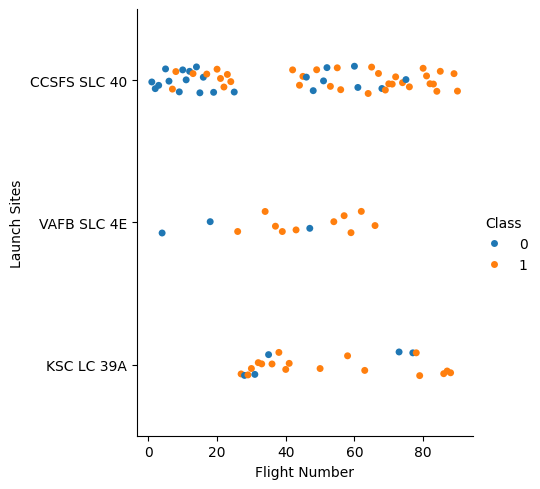

In [25]:
sns.catplot(y='LaunchSite', x='FlightNumber', hue='Class', data=df)
plt.xlabel('Flight Number')
plt.ylabel('Launch Sites')
plt.show()

From this, we can see that VAFB SLC 4E and KSC LC 39A have higher success rates than CCSFS SLC 40.

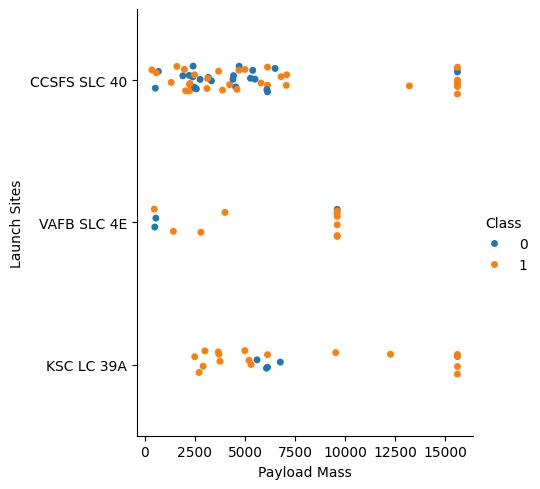

In [26]:
sns.catplot(y='LaunchSite', x='PayloadMass', hue='Class', data=df)
plt.xlabel('Payload Mass')
plt.ylabel('Launch Sites')
plt.show()

For the VAFB SLC 4E launch site, there are no rockets launched for  heavy payload mass (greater than 10000).

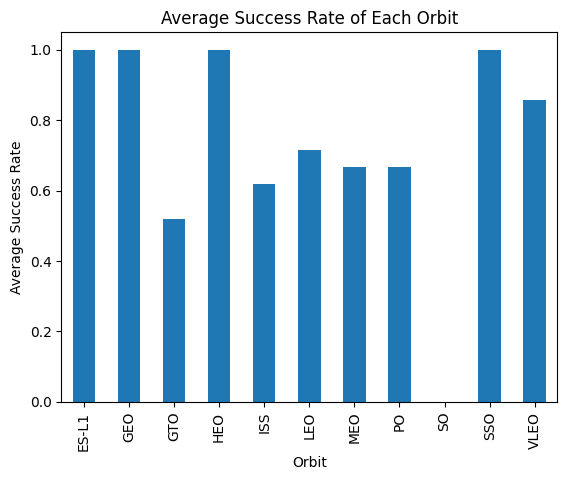

In [27]:
orbit_success_df = df.groupby('Orbit', as_index=False)['Class'].mean()
ax = orbit_success_df.plot.bar('Orbit', 'Class', legend=False)
plt.title('Average Success Rate of Each Orbit')
plt.ylabel('Average Success Rate')
plt.show()

The orbits ES-L1, GEO, HEO, and SSO have the highest success rate.

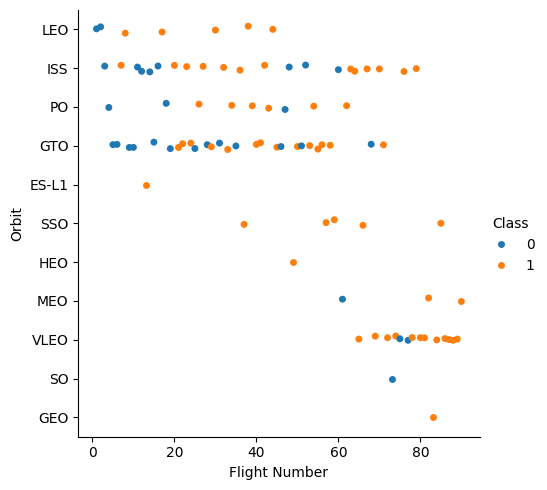

In [28]:
sns.catplot(y='Orbit', x='FlightNumber', hue='Class', data=df)
plt.xlabel('Flight Number')
plt.ylabel('Orbit')
plt.show()

There seems to be a relationship between the success rate and the flight number for the LEO orbit, but that's not the case for ISS and GTO.

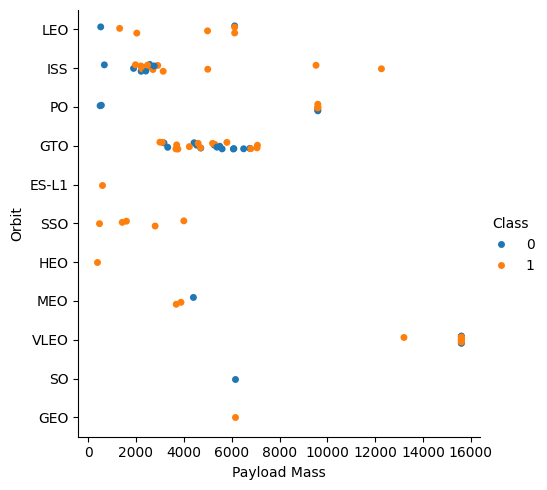

In [29]:
sns.catplot(y='Orbit', x='PayloadMass', hue='Class', data=df)
plt.xlabel('Payload Mass')
plt.ylabel('Orbit')
plt.show()

Besides GTO and MEO, the success rate seems to increase as the payload mass increases.

We can also extract the year values from the 'Date' column to plot the yearly trend of average success rates.

In [30]:
def extract_year(date):
    date = str(date)
    year = date.split("-")[0]
    return year
df['Date'] = df['Date'].map(lambda x: extract_year(x))
df.rename(columns={'Date': 'Year'}, inplace=True)
df.head()

,FlightNumber,Year,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


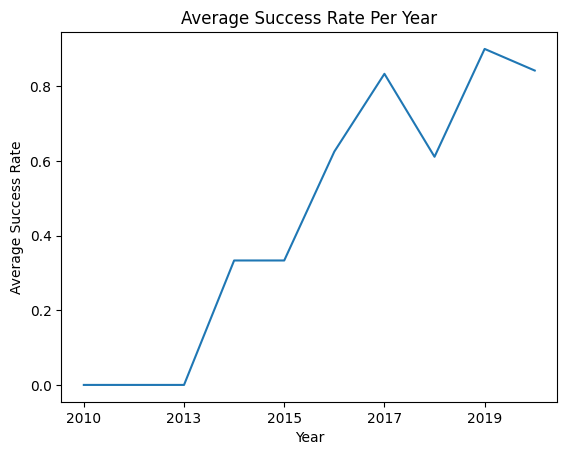

In [31]:
yearly_success_df = df.groupby('Year', as_index=False)['Class'].mean()
yearly_success_df.plot(x='Year', y='Class', legend=False)
plt.xlabel('Year')
plt.ylabel('Average Success Rate')
plt.title('Average Success Rate Per Year')
plt.show()

We can see that the success rate is on an increasing trend annually.

## Classification Models

First, let's define the plotting function that we will use to plot the confusion matrix for each model we build.

In [32]:
def plot_confusion_matrix(y,y_predict, model):
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix for {}'.format(model))
    ax.xaxis.set_ticklabels(['did not land', 'land'])
    ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

Next, let's prepare the features X to be used by creating dummy variables for categorical data, and we will use the 'Class' column as the target Y.

In [33]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins',
               'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
dummies = pd.get_dummies(features[['Orbit', 'LaunchSite', 'LandingPad', 'Serial']])
features = pd.concat([features, dummies], axis=1)
features.drop(columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'], axis=1, inplace=True)
features = features.astype('float64')
features.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X = features
Y = df['Class'].to_numpy()

Let's also standardize the features and split the data into training data and test data.

In [35]:
#Standardize X
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

#Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

Now we are ready to build logistic regression, support vector machine (SVM), decision tree classifier, and K-nearest neighbor (KNN) classifier models to predict launch outcomes. For each of the models, we will build the model with parameters tuned by grid search with cv = 10, calculate the accuracy scores for train data and test data, and plot the confusion matrix for test data.

#### Logistic Regression

In [36]:
parameters = {'C':[0.01, 0.1, 1],
              'penalty':['l2'],
              'solver':['lbfgs', 'liblinear']}
lr = LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear']})

In [37]:
print('tuned parameters:', logreg_cv.best_params_)

tuned parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [38]:
logreg_train_accuracy = logreg_cv.best_score_
print('train data accuracy:', logreg_train_accuracy)

train data accuracy: 0.8214285714285714


In [39]:
logreg_test_accuracy = logreg_cv.score(X_test, Y_test)
print('test data accuracy:', logreg_test_accuracy)

test data accuracy: 0.8333333333333334


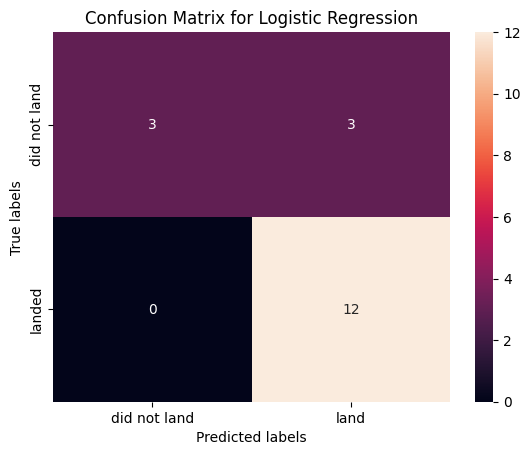

In [40]:
Yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test, Yhat, 'Logistic Regression')

#### SVM

In [41]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [42]:
print('tuned parameters:', svm_cv.best_params_)

tuned parameters: {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}


In [43]:
svm_train_accuracy = svm_cv.best_score_
print('train data accuracy:', svm_train_accuracy)

train data accuracy: 0.8482142857142858


In [44]:
svm_test_accuracy = svm_cv.score(X_test, Y_test)
print('test data accuracy:', svm_test_accuracy)

test data accuracy: 0.8333333333333334


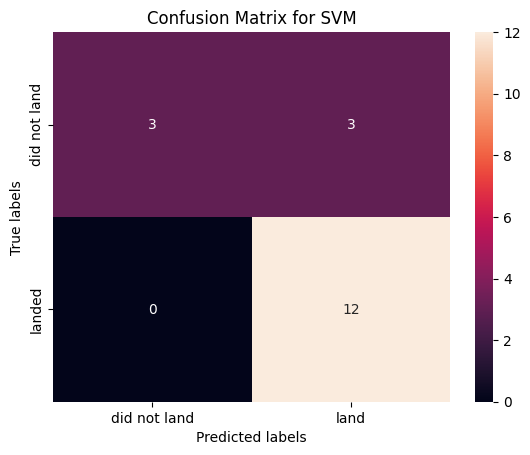

In [45]:
Yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test, Yhat, 'SVM')

#### Decision Tree Classifier

In [46]:
parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [2*n for n in range(1,10)],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10]}
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [47]:
print('tuned parameters:', tree_cv.best_params_)

tuned parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}


In [48]:
tree_train_accuracy = tree_cv.best_score_
print('train data accuracy:', tree_train_accuracy)

train data accuracy: 0.8642857142857142


In [49]:
tree_test_accuracy = tree_cv.score(X_test, Y_test)
print('test data accuracy:', tree_test_accuracy)

test data accuracy: 0.8333333333333334


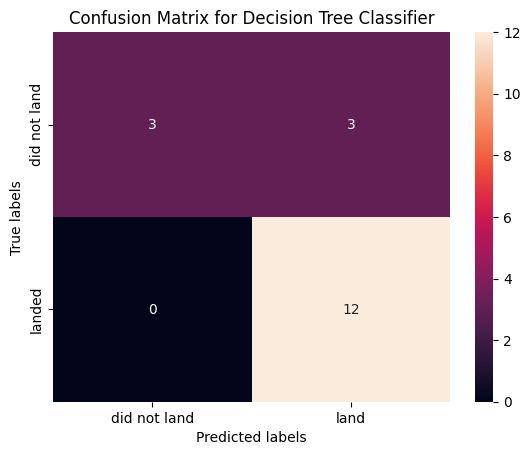

In [50]:
Yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test, Yhat, 'Decision Tree Classifier')

#### KNN Classifier

In [51]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1, 2]}
KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [52]:
print('tuned parameters:', knn_cv.best_params_)

tuned parameters: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}


In [53]:
knn_train_accuracy = knn_cv.best_score_
print('train data accuracy:', knn_train_accuracy)

train data accuracy: 0.8339285714285714


In [54]:
knn_test_accuracy = knn_cv.score(X_test, Y_test)
print('test data accuracy:', knn_test_accuracy)

test data accuracy: 0.7777777777777778


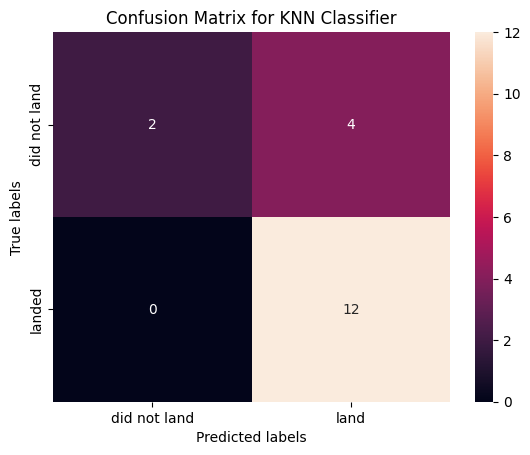

In [55]:
Yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test, Yhat, 'KNN Classifier')

Finally, let's plot a bar chart to compare the accuracy of different models.

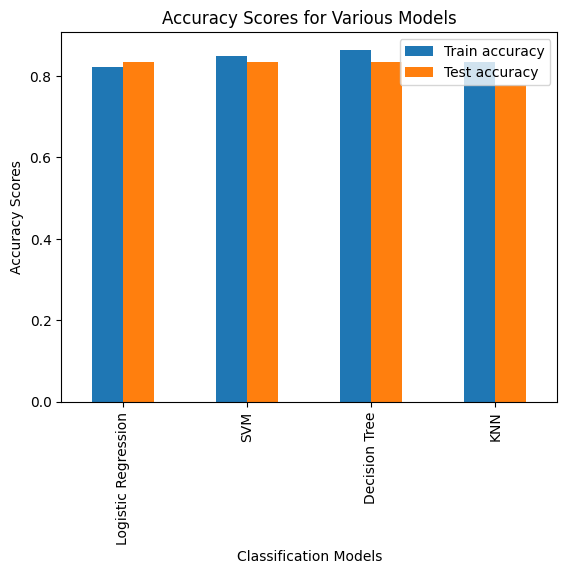

In [56]:
#Making the data frame
model_accuracy_dict = {'Model': ['Logistic Regression', 'SVM', 'Decision Tree', 'KNN'],
                       'Train accuracy': [logreg_train_accuracy, svm_train_accuracy, tree_train_accuracy, knn_train_accuracy],
                       'Test accuracy': [logreg_test_accuracy, svm_test_accuracy, tree_test_accuracy, knn_test_accuracy]}
model_accuracy_df = pd.DataFrame(model_accuracy_dict)
model_accuracy_df.set_index('Model', inplace=True)

#Making the bar chart
model_accuracy_df.plot.bar()
plt.title('Accuracy Scores for Various Models')
plt.xlabel('Classification Models')
plt.ylabel('Accuracy Scores')
plt.show()

We can see that the decision tree classifier is the best model, having the highest train data accuracy and the highest test data accuracy.